# AUROC


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
# do we have the correct env loaded?
assert 'donkey2' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

In [5]:
import numpy as np
fast_model_fast_data_3d = np.load('open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')
fast_model_slow_data_3d = np.load('open-loop-results/nighttime-fast-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')
slow_model_fast_data_3d = np.load('open-loop-results/nighttime-slow-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')
slow_model_slow_data_3d = np.load('open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')


In [6]:
def classify(data):
    classified = np.empty(len(data), dtype= 'U1')
    classified[data < -0.2] = 'L'
    classified[data >= -0.2] = 'C'
    classified[data > 0.2] = 'R'
    return classified

fast_gt_class = classify(fast_model_fast_data_3d[:, 2])
slow_gt_class = classify(slow_model_slow_data_3d[:, 2])


In [7]:
def regression_to_3_class_probabilities(predictions):
    fast_model_fast_data_probas = np.zeros((len(predictions), 3))
    fast_model_fast_data_probas[:, 0] = np.maximum(0, - predictions)
    fast_model_fast_data_probas[:, 1] = 1 - np.abs(predictions)
    fast_model_fast_data_probas[:, 2] = np.maximum(0, predictions)
    return fast_model_fast_data_probas


fast_model_fast_data_probas = regression_to_3_class_probabilities(fast_model_fast_data_3d[:,1])


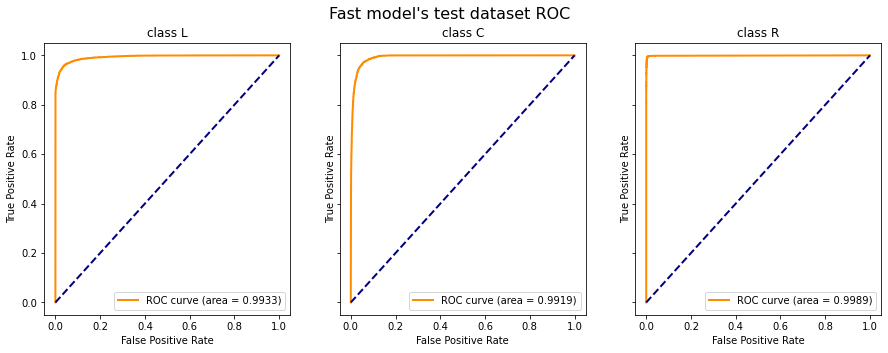

In [15]:
from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


def auroc(gt_class, class_probas, title):
    classes_order = OrderedDict([(0, 'L'), (1, 'C'), (2, 'R')])
    y = label_binarize(gt_class, classes=list(classes_order.values()))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex='all', sharey='all')
    fig.suptitle(title, size=16)
    lw = 2
    for cl, ax in zip(classes_order.keys(), axs.flat):
        fpr[cl], tpr[cl], _ = roc_curve(y[:, cl], class_probas[:, cl])
        roc_auc[cl] = auc(fpr[cl], tpr[cl])
        ax.plot(
            fpr[cl],
            tpr[cl],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.4f)" % roc_auc[cl],
        )
        ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f'class {classes_order[cl]}')
        ax.legend(loc="lower right")
    plt.show()
    return fpr, tpr, roc_auc

fpr, tpr, roc_auc = auroc(fast_gt_class, fast_model_fast_data_probas, "Fast model's test dataset ROC")

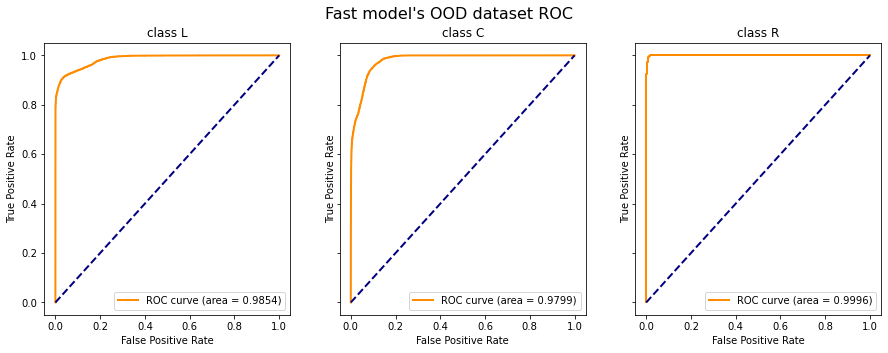

In [16]:

fast_model_slow_data_probas = regression_to_3_class_probabilities(fast_model_slow_data_3d[:,0])
fpr, tpr, roc_auc = auroc(slow_gt_class, fast_model_slow_data_probas, "Fast model's OOD dataset ROC")


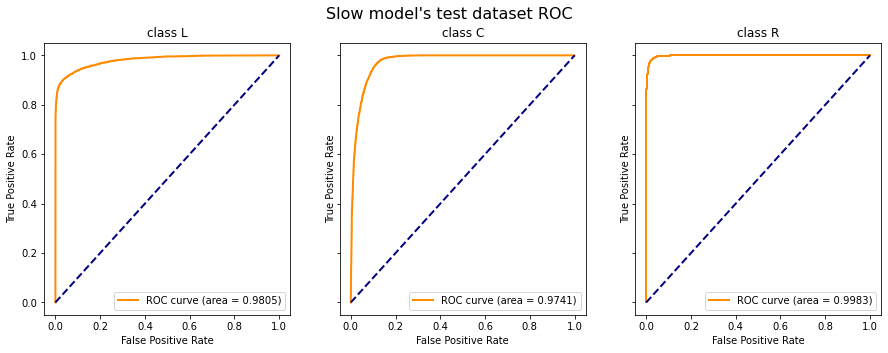

In [21]:
slow_model_slow_data_probas = regression_to_3_class_probabilities(slow_model_slow_data_3d[:,1])
fpr, tpr, roc_auc = auroc(slow_gt_class, slow_model_slow_data_probas, "Slow model's test dataset ROC")


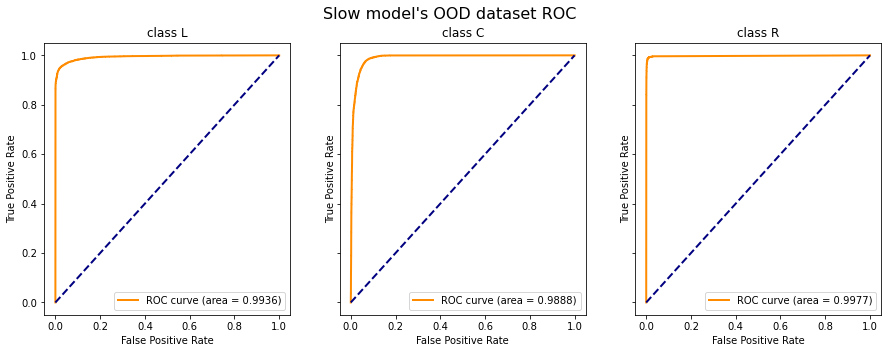

In [20]:
slow_model_fast_data_probas = regression_to_3_class_probabilities(slow_model_fast_data_3d[:,0])
fpr, tpr, roc_auc = auroc(fast_gt_class, slow_model_fast_data_probas, "Slow model's OOD dataset ROC")
